## Mohamed Ashraf Khalaf Hafez 2205201


## CNN from scratch

Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Load MINIST

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def preprocess(batch):
    x, y = batch
    return x.numpy(), y.numpy()


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.51MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.38MB/s]


In [ ]:
def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels):
    m = labels.shape[0]
    log_likelihood = -np.log(predictions[range(m), labels] + 1e-9)
    return np.sum(log_likelihood) / m

def cross_entropy_grad(predictions, labels):
    grad = predictions.copy()
    grad[range(len(labels)), labels] -= 1
    grad /= len(labels)
    return grad

In [ ]:
class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask
    def backward(self, grad_output):
        return grad_output * self.mask

class Flatten:
    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(x.shape[0], -1)
    def backward(self, grad_output):
        return grad_output.reshape(self.input_shape)

class Dense:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * 0.01
        self.b = np.zeros((1, out_dim))
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W) + self.b
    def backward(self, grad, lr):
        dW = np.dot(self.x.T, grad)
        db = np.sum(grad, axis=0, keepdims=True)
        dx = np.dot(grad, self.W.T)
        self.W -= lr * dW
        self.b -= lr * db
        return dx

In [ ]:
def pad2d(x, pad):
    return np.pad(x, ((0,0), (0,0), (pad,pad), (pad,pad)), mode='constant') if pad > 0 else x

class Conv2D:
    def __init__(self, name, in_channels=1, num_filters=16, stride=1, size=3, padding=0, activation='relu'):
        self.name = name
        self.filters = np.random.randn(num_filters, in_channels, size, size) * 0.1
        self.stride = stride
        self.size = size
        self.padding = padding
        self.activation = activation
        self.last_input = None

    def forward(self, x):
        self.last_input = x
        B, C, H, W = x.shape
        KH, KW = self.size, self.size
        F = self.filters.shape[0]

        x_p = pad2d(x, self.padding)
        H_p, W_p = x_p.shape[2], x_p.shape[3]
        OH = (H_p - KH) // self.stride + 1
        OW = (W_p - KW) // self.stride + 1

        out = np.zeros((B, F, OH, OW))
        for b in range(B):
            for f in range(F):
                for i in range(OH):
                    for j in range(OW):
                        hs = i * self.stride
                        ws = j * self.stride
                        patch = x_p[b, :, hs:hs+KH, ws:ws+KW]
                        out[b, f, i, j] = np.sum(self.filters[f] * patch)

        if self.activation == 'relu':
            out = np.maximum(0, out)
        return out

    def backward(self, d_out, learning_rate=0.005):
        x = self.last_input
        B, C, H, W = x.shape
        F, _, KH, KW = self.filters.shape

        x_p = pad2d(x, self.padding)
        dx_p = np.zeros_like(x_p)
        d_filters = np.zeros_like(self.filters)
        OH, OW = d_out.shape[2], d_out.shape[3]

        if self.activation == 'relu':
            out = self.forward(x)
            d_out = d_out * (out > 0)

        for b in range(B):
            for f in range(F):
                for i in range(OH):
                    for j in range(OW):
                        hs = i * self.stride
                        ws = j * self.stride
                        patch = x_p[b, :, hs:hs+KH, ws:ws+KW]
                        d_filters[f] += d_out[b, f, i, j] * patch
                        dx_p[b, :, hs:hs+KH, ws:ws+KW] += d_out[b, f, i, j] * self.filters[f]

        self.filters -= learning_rate * d_filters
        if self.padding > 0:
            return dx_p[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            return dx_p

In [ ]:
class MaxPool2D:
    def __init__(self, size=2, stride=2):
        self.size = size
        self.stride = stride
    def forward(self, x):
        self.x = x
        B, C, H, W = x.shape
        OH = H // self.size
        OW = W // self.size
        y = np.zeros((B, C, OH, OW))
        self.mask = np.zeros_like(x)
        for i in range(OH):
            for j in range(OW):
                hs = i * self.stride
                ws = j * self.stride
                window = x[:, :, hs:hs+self.size, ws:ws+self.size]
                max_vals = np.max(window, axis=(2,3), keepdims=True)
                self.mask[:, :, hs:hs+self.size, ws:ws+self.size] = (window == max_vals)
                y[:, :, i, j] = max_vals.squeeze()
        return y
    def backward(self, grad):
        dx = np.zeros_like(self.x)
        OH, OW = grad.shape[2], grad.shape[3]
        for i in range(OH):
            for j in range(OW):
                hs = i * self.stride
                ws = j * self.stride
                dx[:, :, hs:hs+self.size, ws:ws+self.size] += self.mask[:, :, hs:hs+self.size, ws:ws+self.size] * grad[:, :, i:i+1, j:j+1]
        return dx

In [ ]:
class CNN:
    def __init__(self):
        self.conv1 = Conv2D(name="conv1", in_channels=1, num_filters=32, size=3, padding=1)
        self.relu1 = ReLU()
        self.pool1 = MaxPool2D(size=2)
        self.conv2 = Conv2D(name="conv2", in_channels=32, num_filters=64, size=3, padding=1)
        self.relu2 = ReLU()
        self.pool2 = MaxPool2D(size=2)
        self.flatten = Flatten()
        self.fc1 = Dense(7 * 7 * 64, 128)
        self.fc2 = Dense(128, 10)

    def forward(self, x):
        x = self.conv1.forward(x)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)
        x = self.conv2.forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)
        x = self.flatten.forward(x)
        x = self.fc1.forward(x)
        x = self.fc2.forward(x)
        return softmax(x)

    def backward(self, grad, lr):
        grad = self.fc2.backward(grad, lr)
        grad = self.fc1.backward(grad, lr)
        grad = self.flatten.backward(grad)
        grad = self.pool2.backward(grad)
        grad = self.relu2.backward(grad)
        grad = self.conv2.backward(grad, lr)
        grad = self.pool1.backward(grad)
        grad = self.relu1.backward(grad)
        grad = self.conv1.backward(grad, lr)
        return grad

In [ ]:
class SimpleCNN:
    def __init__(self):
        self.model = CNN()

    def train(self, train_loader, val_loader, epochs=5, lr=0.01):
      train_losses, val_losses = [], []
      train_accuracies, val_accuracies = [], []

      for epoch in range(epochs):
          total_loss = 0
          all_preds, all_labels = [], []
          for x, y in train_loader:
              x, y = x.numpy(), y.numpy()
              out = self.model.forward(x)
              loss = cross_entropy_loss(out, y)
              grad = cross_entropy_grad(out, y)
              self.model.backward(grad, lr)
              total_loss += loss
              preds = np.argmax(out, axis=1)
              all_preds.extend(preds)
              all_labels.extend(y)

          train_losses.append(total_loss / len(train_loader))
          train_acc = accuracy_score(all_labels, all_preds)
          train_accuracies.append(train_acc)

          val_preds, val_labels = self.evaluate(val_loader)
          val_loss = cross_entropy_loss(self.model.forward(x), y)
          val_acc = accuracy_score(val_labels, val_preds)
          val_losses.append(val_loss)
          val_accuracies.append(val_acc)

          print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

      return train_losses, val_losses, train_accuracies, val_accuracies


    def evaluate(self, data_loader):
        all_preds, all_labels = [], []
        for x, y in data_loader:
            x, y = x.numpy(), y.numpy()
            preds = np.argmax(self.model.forward(x), axis=1)
            all_preds.extend(preds)
            all_labels.extend(y)
        return all_preds, all_labels

In [ ]:
cnn = SimpleCNN()
train_losses, val_losses, train_accuracies, val_accuracies = cnn.train(train_loader, test_loader, epochs=5, lr=0.01)

<ipython-input-45-2aac35cd261a>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = criterion(self.model(torch.tensor(x).float()), torch.tensor(y).long()).item()  # assuming val uses same structure


Epoch 1: Train Loss = 2.0796, Train Acc = 0.2560, Val Acc = 0.5458


<ipython-input-45-2aac35cd261a>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = criterion(self.model(torch.tensor(x).float()), torch.tensor(y).long()).item()  # assuming val uses same structure


Epoch 2: Train Loss = 0.8956, Train Acc = 0.7420, Val Acc = 0.6177


<ipython-input-45-2aac35cd261a>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = criterion(self.model(torch.tensor(x).float()), torch.tensor(y).long()).item()  # assuming val uses same structure


Epoch 3: Train Loss = 0.5316, Train Acc = 0.8180, Val Acc = 0.7442


<ipython-input-45-2aac35cd261a>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = criterion(self.model(torch.tensor(x).float()), torch.tensor(y).long()).item()  # assuming val uses same structure


Epoch 4: Train Loss = 0.4769, Train Acc = 0.8560, Val Acc = 0.7384
Epoch 5: Train Loss = 0.3786, Train Acc = 0.8640, Val Acc = 0.7748


<ipython-input-45-2aac35cd261a>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = criterion(self.model(torch.tensor(x).float()), torch.tensor(y).long()).item()  # assuming val uses same structure


In [ ]:
test_preds, test_labels = cnn.evaluate(test_loader)
acc = accuracy_score(test_labels, test_preds)
prec = precision_score(test_labels, test_preds, average='macro')
rec = recall_score(test_labels, test_preds, average='macro')
f1 = f1_score(test_labels, test_preds, average='macro')

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.7748
Precision: 0.7946
Recall: 0.7703
F1 Score: 0.7690


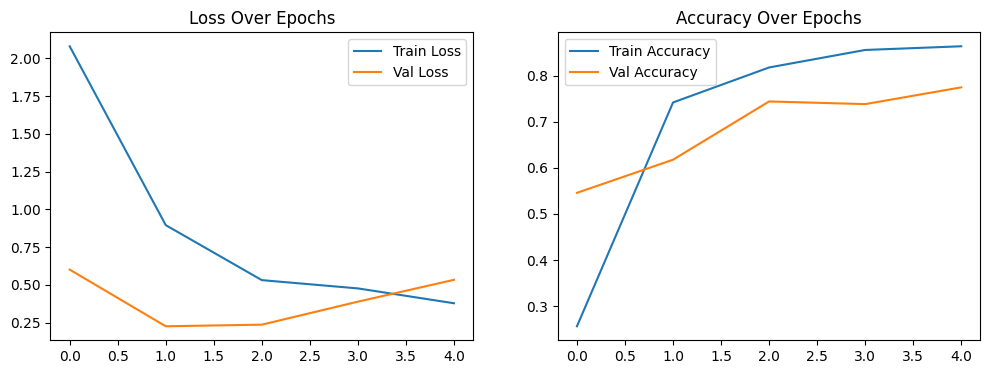

In [ ]:
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

## Provided Model (using colab gpu)

Using device: cpu
Epoch [1/5], Loss: 243.4426, Test Accuracy: 0.9718
Epoch [2/5], Loss: 65.3535, Test Accuracy: 0.9857
Epoch [3/5], Loss: 45.8207, Test Accuracy: 0.9858
Epoch [4/5], Loss: 34.8049, Test Accuracy: 0.9875
Epoch [5/5], Loss: 28.0455, Test Accuracy: 0.9894


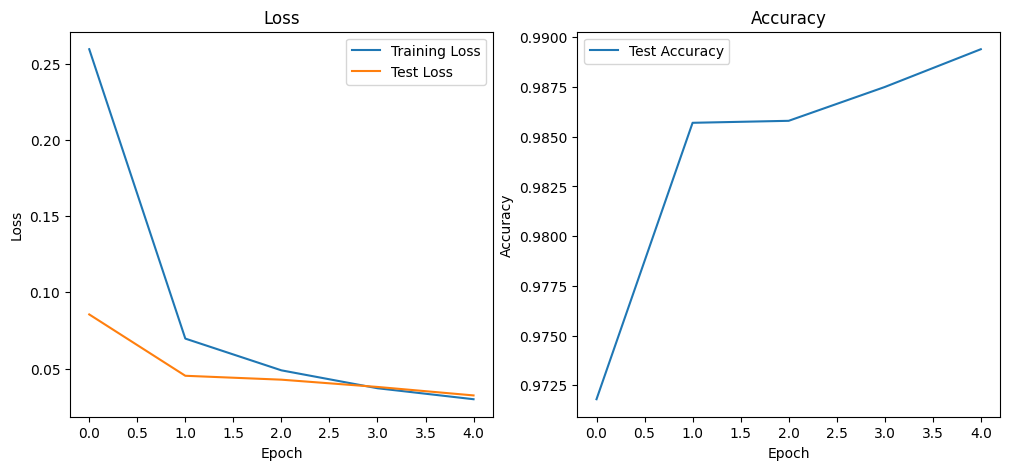


Final Evaluation on Test Set:
Accuracy: 0.9894
Precision: 0.9893
Recall: 0.9892
F1 Score: 0.9893


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# coab GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
train_losses, test_losses, accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    test_losses.append(test_loss / len(test_loader))
    accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Test Accuracy: {accuracy:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("\nFinal Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Recall: {recall_score(all_labels, all_preds, average='macro'):.4f}")
print(f"F1 Score: {f1_score(all_labels, all_preds, average='macro'):.4f}")